# Stock Market Forecasting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates #dates format
%matplotlib inline
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
dateparse= lambda dates:pd.datetime.strptime(dates,'%Y-%m-%d')

In [5]:
df =pd.read_csv("D:/DECODER/projects file/gs.us.txt", sep=',', parse_dates=['Date'], index_col=['Date'], date_parser=dateparse)

<ipython-input-2-36c4f5ec905c>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse= lambda dates:pd.datetime.strptime(dates,'%Y-%m-%d')


In [6]:
df

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1999-05-04,67.665,68.780,62.329,62.659,24472946,0
1999-05-05,62.213,62.213,58.991,61.547,8295140,0
1999-05-06,60.542,61.773,59.712,60.488,3185852,0
1999-05-07,60.488,66.671,59.429,65.998,5331091,0
1999-05-10,65.331,65.441,62.549,62.941,2839054,0
...,...,...,...,...,...,...
2017-11-06,243.500,244.579,241.670,243.490,1733854,0
2017-11-07,243.910,244.980,238.840,239.810,2435057,0
2017-11-08,239.200,242.320,237.550,241.250,2349422,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4661 entries, 1999-05-04 to 2017-11-10
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     4661 non-null   float64
 1   High     4661 non-null   float64
 2   Low      4661 non-null   float64
 3   Close    4661 non-null   float64
 4   Volume   4661 non-null   int64  
 5   OpenInt  4661 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 254.9 KB


In [13]:
df.describe()


,Open,High,Low,Close,Volume,OpenInt
count,4661.000000,4661.000000,4661.000000,4661.000000,4.661000e+03,4661.0
mean,128.617729,130.219184,127.028745,128.650169,6.257749e+06,0.0
std,47.634295,47.868451,47.391684,47.624879,7.243749e+06,0.0
min,49.252000,49.743000,43.241000,47.429000,0.000000e+00,0.0
25%,85.705000,87.093000,84.423000,85.771000,2.807258e+06,0.0
50%,128.950000,130.390000,126.810000,128.490000,4.144442e+06,0.0
75%,161.310000,163.120000,159.590000,161.330000,6.714921e+06,0.0
max,252.000000,253.420000,249.810000,251.180000,1.253138e+08,0.0


In [14]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

# Exploratory Data Analysis (EDA)


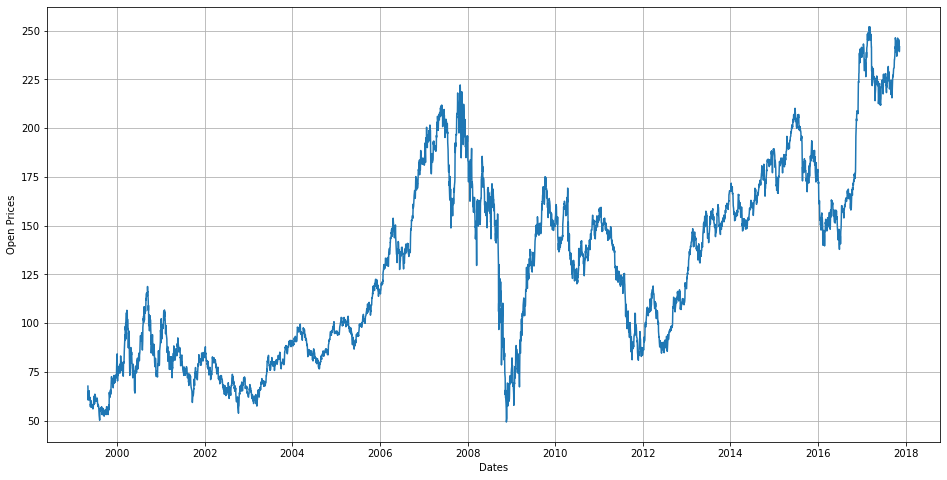

In [16]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(df["Open"])
plt.show()

# Autocorrelation plot

In [20]:
values = pd.DataFrame(df['Open'].values)
dataframe=pd.concat([values,values.shift(1),values.shift(5),values.shift(10),values.shift(30)], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
dataframe                 

,t,t+1,t+5,t+10,t+30
0,67.665,NaN,NaN,NaN,NaN
1,62.213,67.665,NaN,NaN,NaN
2,60.542,62.213,NaN,NaN,NaN
3,60.488,60.542,NaN,NaN,NaN
4,65.331,60.488,NaN,NaN,NaN
...,...,...,...,...,...
4656,243.500,245.370,240.10,244.39,230.77
4657,243.910,243.500,240.68,243.60,230.86
4658,239.200,243.910,243.89,246.16,234.07
4659,239.510,239.200,244.69,242.61,235.00


In [21]:
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.998288  0.992929  0.987001  0.954921
t+1   0.998288  1.000000  0.994216  0.988282  0.956678
t+5   0.992929  0.994216  1.000000  0.992890  0.963463
t+10  0.987001  0.988282  0.992890  1.000000  0.971829
t+30  0.954921  0.956678  0.963463  0.971829  1.000000


# Dickey-Fuller Method to check stationary and seasonality

In [30]:
def tsplot(y, lags=None, figsize=(16, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y=pd.Series(y)
    
    with plt.style.context(style='bmh'):
        fig=plt.figure(figsize=figsize)
        layout=(2,2)
        ts_ax=plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax=plt.subplot2grid(layout,(1,0))
        pacf_ax=plt.subplot2grid(layout,(1,1))
        
        y.plot(ax=ts_ax)
        p_value=sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title("Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout
        

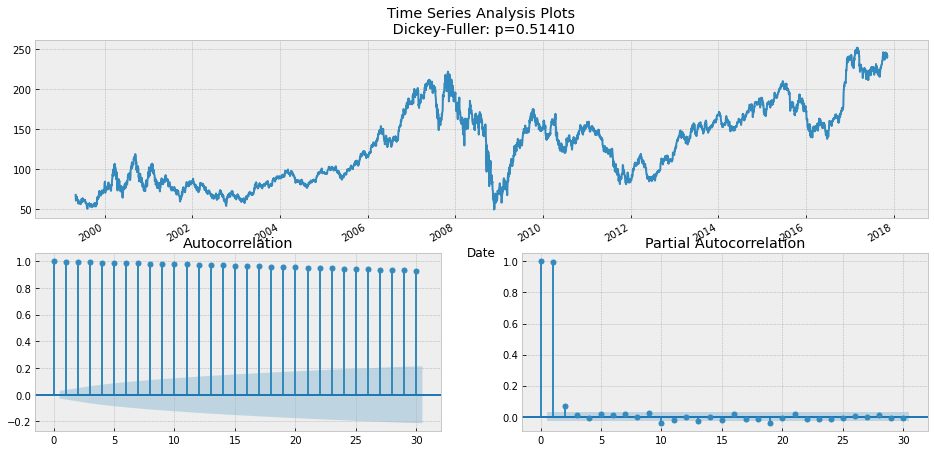

In [31]:
tsplot(df.Open, lags=30)

In [ ]:
#Inference
# the data is not stationary
# there is no seasonality

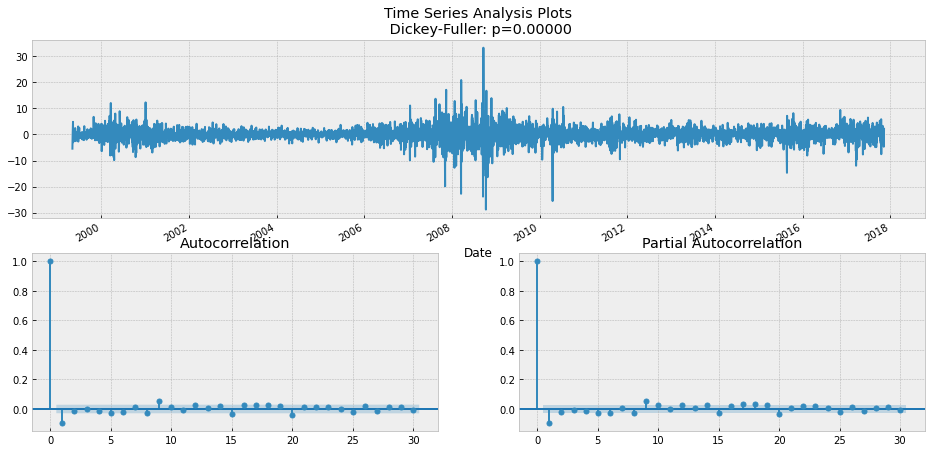

In [33]:
data = df.copy(deep=False)
data1=df.copy(deep=False)
data1.Open=data1.Open-data1.Open.shift(1)
tsplot(data1.Open[1:], lags=30)

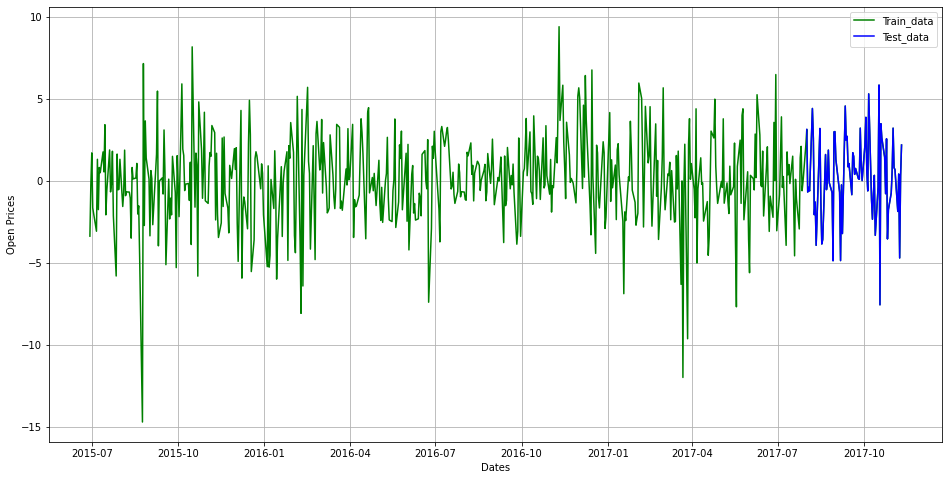

In [34]:
train_data, test_data = data[1:-73], data[-73:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'].tail(600), 'green', label='Train_data')
plt.plot(test_data['Open'], 'blue', label='Test_data')
plt.legend()
plt.show()

# Mean Value plot

In [35]:
mean_value = data['Open'].mean()

mean_value

0.037344420600858366

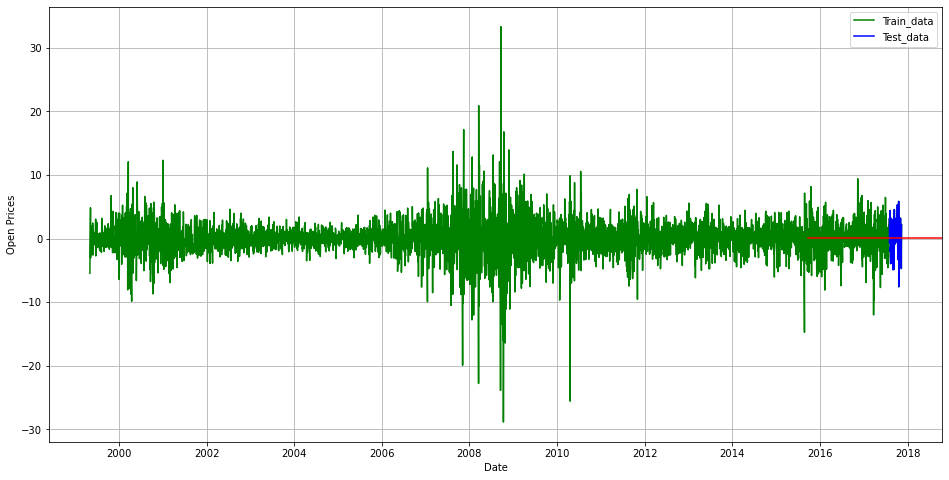

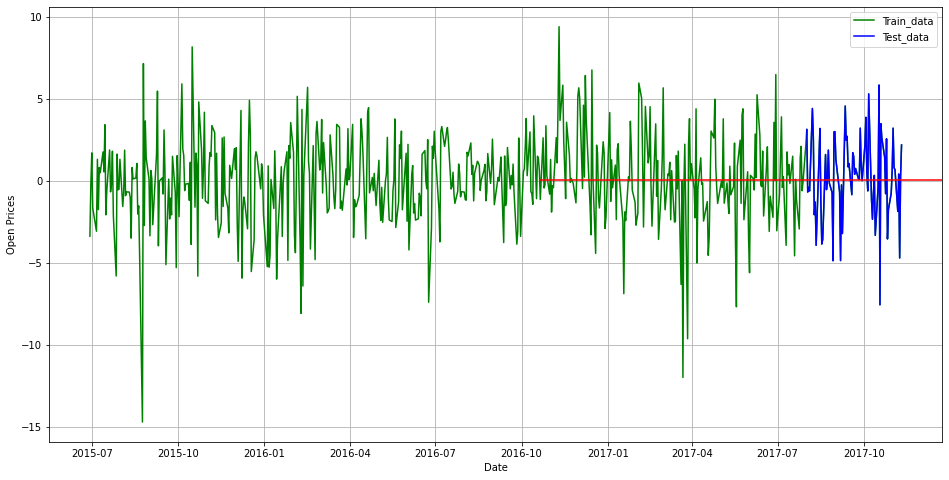

In [37]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Open Prices')
plt.plot(data['Open'], 'green', label='Train_data')
plt.plot(test_data['Open'], 'blue', label='Test_data')
plt.axhline(y=mean_value, xmin = 0.85, xmax=1, color='red')
plt.legend()

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Open Prices')
plt.plot(data['Open'].tail(600), 'green', label='Train_data')
plt.plot(test_data['Open'], 'blue', label='Test_data')
plt.axhline(y=mean_value, xmin = 0.55, xmax=1, color='red')
plt.legend()
plt.show()

In [38]:
print('MSE:' + str(mean_squared_error(test_data['Open'], np.full(len(test_data), mean_value))))
print('MAE:' + str(mean_absolute_error(test_data['Open'], np.full(len(test_data), mean_value))))
print('RMSE:' + str(sqrt(mean_squared_error(test_data['Open'], np.full(len(test_data), mean_value)))))

MSE:6.614792639144097
MAE:1.9907383591040042
RMSE:2.571923917837403


 # Model Building and Validation


## Autoregressive model

In [39]:
train_ar = train_data['Open']
test_ar = test_data['Open']

model = AR(train_ar)
model_fit = model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)
C:\

In [42]:
window = model_fit.k_ar
coef = model_fit.params

In [41]:
coef

const       0.033779
L1.Open    -0.100453
L2.Open    -0.022493
L3.Open    -0.005659
L4.Open    -0.017920
L5.Open    -0.036463
L6.Open    -0.024013
L7.Open    -0.002484
L8.Open    -0.016880
L9.Open     0.052729
L10.Open    0.023924
L11.Open    0.003598
L12.Open    0.022555
L13.Open    0.010369
L14.Open    0.023898
L15.Open   -0.025001
L16.Open    0.030307
L17.Open    0.035237
L18.Open    0.032428
L19.Open    0.021392
L20.Open   -0.030216
L21.Open    0.012711
L22.Open    0.019365
L23.Open    0.021047
L24.Open    0.004986
L25.Open   -0.019793
L26.Open    0.010853
L27.Open   -0.010130
L28.Open    0.009493
L29.Open    0.015151
L30.Open   -0.004683
L31.Open    0.033767
dtype: float64

In [43]:
window

31

In [44]:
history = train_ar[len(train_ar) - window:]
history = [history[i] for i in range(len(history))]

In [45]:
predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window, length)]
    yhat = coef[0]
    
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)    

Lag: 31


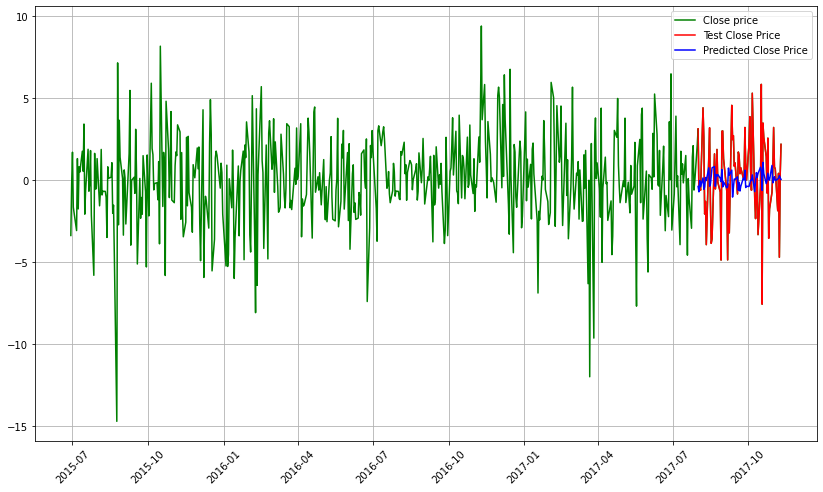

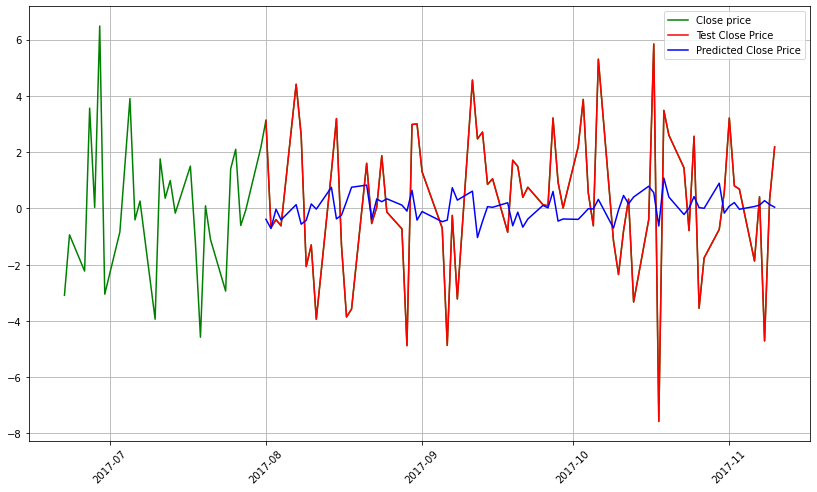

In [46]:
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Close price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test Close Price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted Close Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.figure(figsize=(14,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label = 'Close price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test Close Price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted Close Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [47]:
print('MSE:' + str(mean_squared_error(test_data['Open'], predictions)))
print('MAE:' + str(mean_absolute_error(test_data['Open'], predictions)))
print('RMSE:' + str(sqrt(mean_squared_error(test_data['Open'], predictions))))

MSE:6.564935200370728
MAE:2.0082033669768165
RMSE:2.5622129498483783


# Moving Average Model


In [58]:
train_ma = train_data['Open']
test_ma = test_data['Open']

history = [x for x in train_ma]
y = test_ma


predictions=list()
model = ARMA(history, order=(0,8))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)

In [59]:
history.append(y[0])
for i in range(1, len(y)):
    model = ARMA(history, order=(0,8))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = y[i]
    history.append(obs)

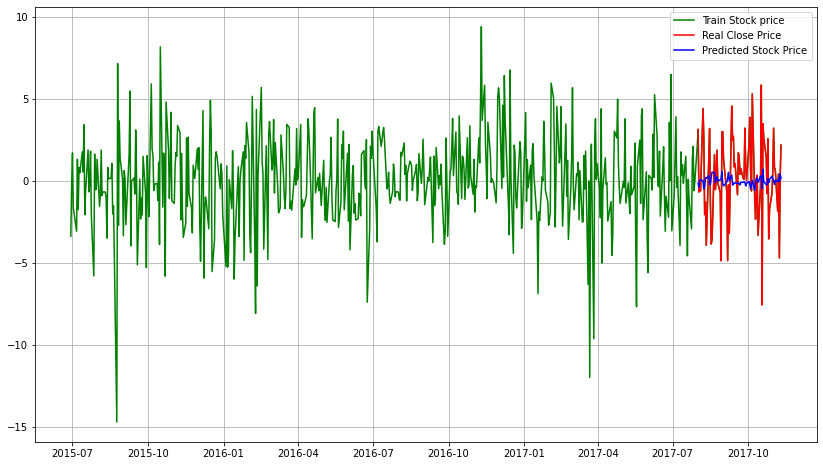

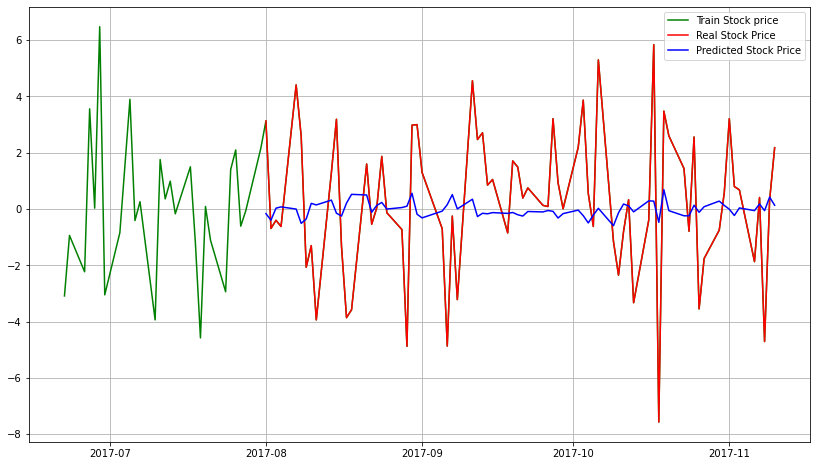

In [51]:
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock price')
plt.plot(test_data.index, y, color='red', label='Real Close Price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted Stock Price')
plt.grid(True)
plt.legend()

plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label = 'Train Stock price')
plt.plot(test_data.index, y, color='red', label='Real Stock Price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted Stock Price')
plt.grid(True)
plt.legend()
plt.show()

In [52]:
print('MSE:' + str(mean_squared_error(y, predictions)))
print('MAE:' + str(mean_absolute_error(y, predictions)))
print('RMSE:' + str(sqrt(mean_squared_error(y, predictions))))

MSE:6.584860381826423
MAE:2.001128904117314
RMSE:2.566098279845576
